<a href="https://colab.research.google.com/github/alexanderkersten/eae-dsaa/blob/main/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Unsupervised algorithms are those whose training data consists of a set of input variables $X$ without a target variable $Y$.

There are two categories:

* **Clustering**: discover groups with similar features within a dataset.

* **Dimensionality reduction**: reduce a dataset with a high number of dimensions to two or three ones. This reduction will allow the visualization as well as a better knowledge about your data.

### Applications

* **Customer segmentation**: the market is divided into smaller segments of buyers who have different needs, characteristics and behaviors to apply different strategies. **Note:** You could apply a customer segmentation using the CRM exercise based on $age$, $GDP$, $gender$, $ first$ $purchase$, $visits$, .etc.

![](https://i.pinimg.com/originals/d7/2f/7b/d72f7bde33d814881a5d058212228514.png)

* **Fraud detection**: identify which transactions can be considered false pretenses. It is about finding anomalous behaviours which are not related to the general behaviour of the rest of the population.

Kaggle example:
http://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval)

* **Face detection using PCA**: principal component analysis is used to reduce the number of variables. The data is compressed in such a way that the main characteristics are preserved. In the case of an image where a face appears, we know that not all the pixels represent the main features of the face. Using PCA, we extract the main ones which define a face and reduce dimensions.  

PCA example from scratch to detect faces:

https://medium.com/@reubenrochesingh/building-face-detector-using-principal-component-analysis-pca-from-scratch-in-python-1e57369b8fc5

# Data generation

*K-means* technique is an unsupervised algorithm from *Clustering* category.

Its purpose is to partition a set of $n$ observations into $k$ groups where each observation belongs to the group whose **mean value is the closest**.

In [1]:
#from IPython.display import Image
#from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns # for plot styling
import numpy as np

We create a two dimensional example using one of the $sklearn$ library component called $make\_blobs$ to generate clusters.

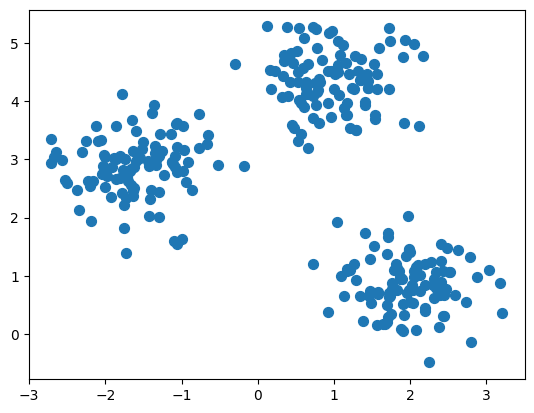

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=3, cluster_std=0.50, random_state=0)  # Generate example with 300 points and 3 centers

plt.scatter(X[:, 0], X[:, 1], s=50)  # Scatter plot to visualize it

In [3]:
help(make_blobs)

Help on function make_blobs in module sklearn.datasets._samples_generator:

make_blobs(n_samples=100, n_features=2, *, centers=None, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=None, return_centers=False)
    Generate isotropic Gaussian blobs for clustering.
    
    Read more in the :ref:`User Guide <sample_generators>`.
    
    Parameters
    ----------
    n_samples : int or array-like, default=100
        If int, it is the total number of points equally divided among
        clusters.
        If array-like, each element of the sequence indicates
        the number of samples per cluster.
    
        .. versionchanged:: v0.20
            one can now pass an array-like to the ``n_samples`` parameter
    
    n_features : int, default=2
        The number of features for each sample.
    
    centers : int or ndarray of shape (n_centers, n_features), default=None
        The number of centers to generate, or the fixed center locations.
        If n_samples 

We can see that the number of groups are 3. The ${K-means}$ algorithm detects automatically to which group each data point has to be assigned:

# Model training



In [4]:
from sklearn.cluster import KMeans # Load kmeans class

kmeans = KMeans(n_clusters=3)      # Number of groups are pre-defined
kmeans.fit(X)                      # Training

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

# Model inference

In [6]:
y_predicted = kmeans.predict(X)       # Prediction
y_predicted

array([2, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 1, 0, 2,
       1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 2, 0, 0, 2, 1, 1, 2, 0, 1, 0,
       2, 1, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1,
       2, 0, 2, 2, 0, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       2, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 1,
       0, 0, 1, 1, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 1, 1, 1,
       2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 0,
       2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 1,
       2, 1, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0,
       0, 0, 0, 1, 0, 0, 2, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0,
       2, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0], d

## What is happening

Each of the 300 points has been associated with one of the three previously set groups:

# Visualize how k-means works

## Figure out the center positions

In [7]:
centers = kmeans.cluster_centers_

print(centers)

[[-1.59458393  2.86866086]
 [ 1.96887266  0.84517309]
 [ 0.95959254  4.36085244]]


We represent the points with the colour associated to their specific group. We also plot the centroids groups which are defined as the minimum mean distance of each set.

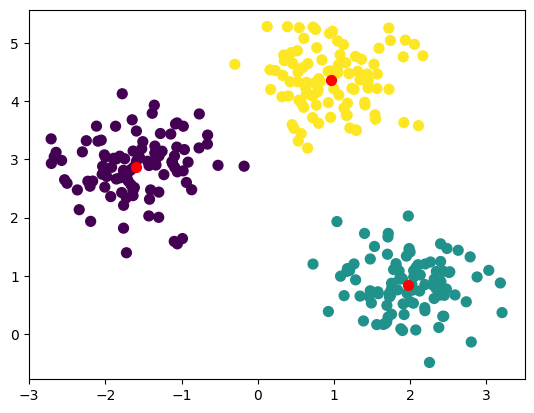

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y_predicted, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)

$K-means$ algorithm assigns the points to the clusters as you would have done.

The entire point is knowing how it works. The good news is this methodology is very simple and we could implement it by ourselves. This method is based on the **Expectation-Maximization algorithm** and the approach consists on:

* 1. Estimate the centroids
* 2. Repeat the process until convergence is reached:
        * *Expectation step*: Assign the points to the closest cluster.
        * *Maximization step*: Set the centroids based on the new computed mean.

See the following code:

In [11]:
from sklearn.metrics import pairwise_distances_argmin
import math

def find_clusters(X, centers):
    """
    Find the clusters within a dataset
    :param iterable X: datasets
    :param iterable centers: initial solution
    """
    # Initial parameters
    iters = 0
    n_clusters = len(centers)                    # Number of clusters
    centers_iters = []                           # Save centers for each iteration
    labels_iters = []                            # Save assigments for each iteration

    while True:
        # Assign the points to the closest group
        labels = pairwise_distances_argmin(X, centers)

        # Save results
        centers_iters.append(centers)
        labels_iters.append(labels)

        # Reallocate the centroids
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # Check convergence
        # In this case we're forcing the function to reach the same center as the cluster
        if np.all(centers == new_centers):
            break

        centers = new_centers
        iters += 1
    return centers_iters, labels_iters, iters

In [12]:
def visualize_kmeans_process(centers_iters, labels_iters, n_clusters, iters):
    """
    Visualize the kmeans process for each iteration
    :param iterable centers_iters: centers for each iteration
    :param iterable labels: assigments for each iteration
    :param int n_clusters: number of clusters
    :param int iters: number of iteration until finding the convergence
    """
    columns = iters+1
    iters = 0
    fig, axs = plt.subplots(1, columns, figsize=(20, 6))
    for col in range(0, columns):
        axs[col].scatter(X[:, 0], X[:, 1], c=labels_iters[iters], s=50, cmap='viridis')
        for cluster in range(n_clusters):
            axs[col].scatter(centers_iters[iters][cluster][0],
                                  centers_iters[iters][cluster][1], c='red', s=50);
        axs[col].set_title("Iter " + str(iters))
        iters += 1

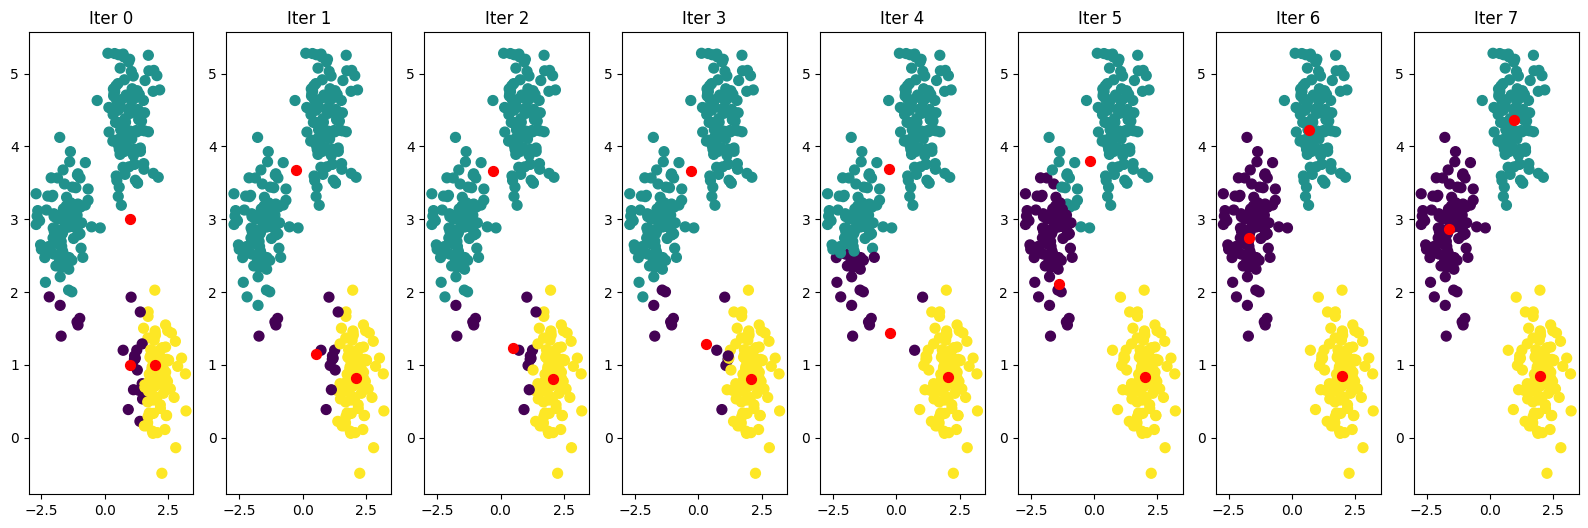

In [18]:
centers = np.array([[1, 1], [2, 3], [2, 1]])
#centers = np.array([[1, 1], [1, 3], [2, 1]])

centers_iters, labels_iters, iters = find_clusters(X, centers)

n_clusters = len(centers)
visualize_kmeans_process(centers_iters, labels_iters, n_clusters, iters)

In [ ]:
help(kmeans)

Help on KMeans in module sklearn.cluster._kmeans object:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centroids using sampling based on
 |      an empirical probability distribution of the points' contribution to the
 |      overall inertia. This technique speeds up convergence. The algorithm
 |      implemented is "greedy k-means++". It differs from the vanilla k-means++
 |      by making several 

The first graph shows an initial cluster assignment that is not the desired one because of the random centroids used.

However, the centroids are getting closer to their corresponding groups until the solution coverges. **It happens when the distance of the points to the closest centroid does not produce new assigments**

## Does the result depend on the initial centroids?

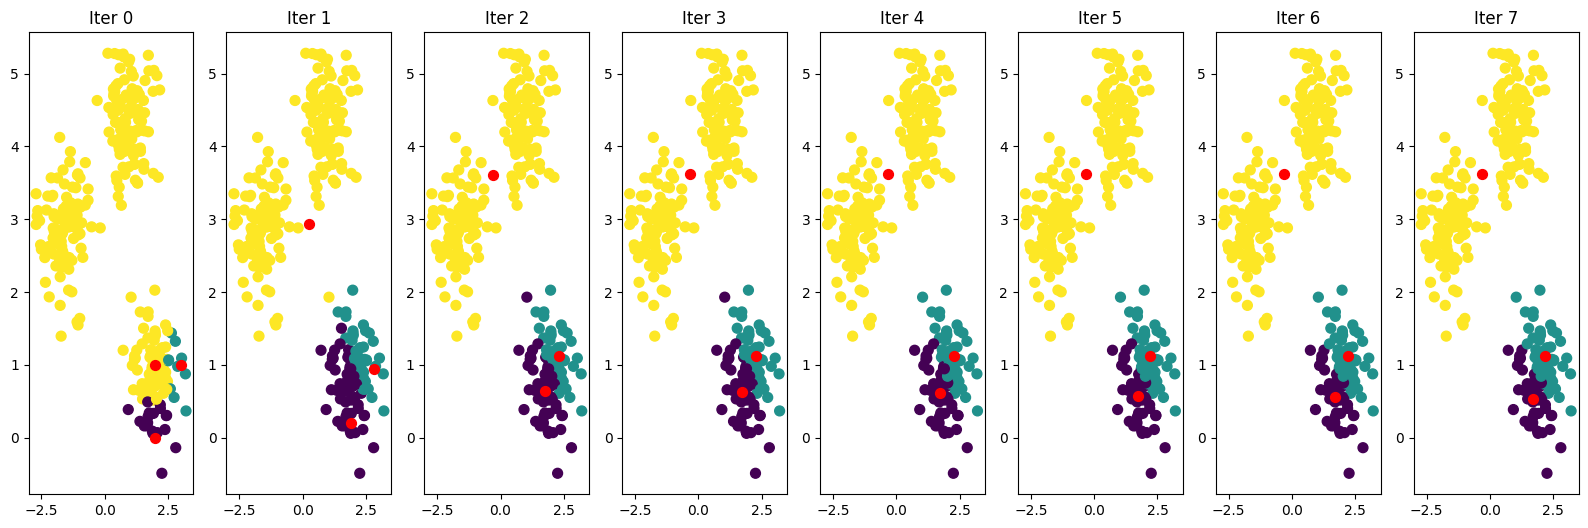

In [19]:
centers = np.array([[2, 0], [3, 1], [2, 1]])

centers_iters, labels_iters, iters = find_clusters(X, centers)

n_clusters = len(centers)
visualize_kmeans_process(centers_iters, labels_iters, n_clusters, iters)

## Using only two groups

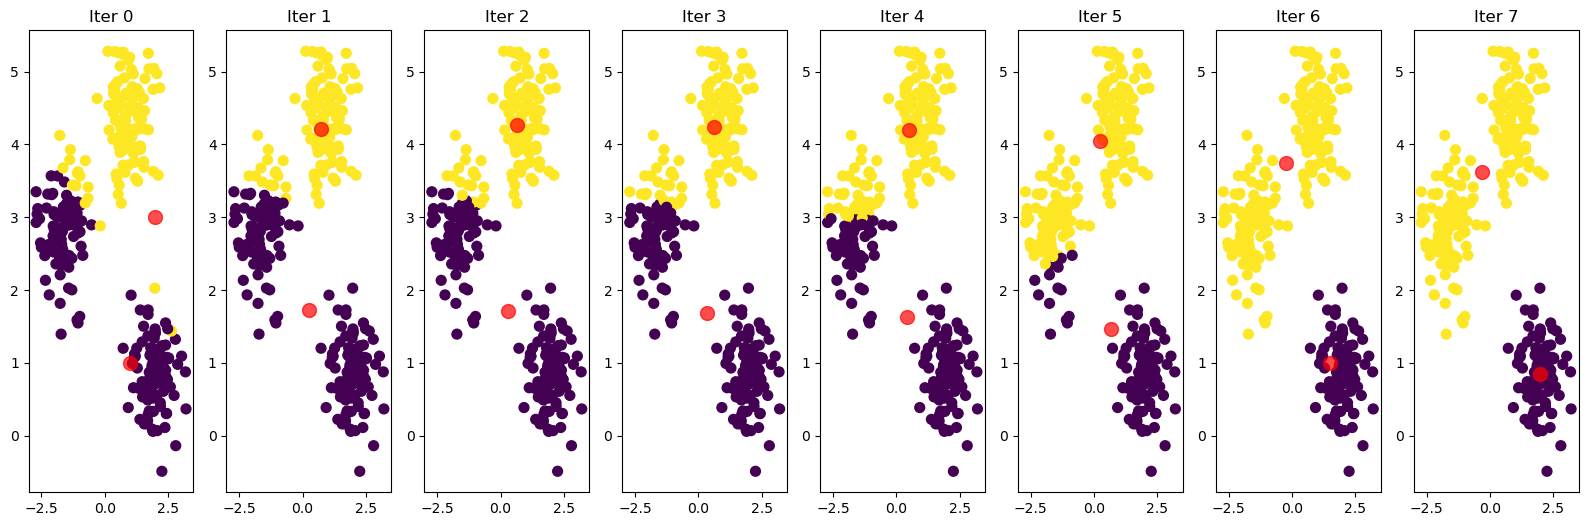

In [ ]:
centers = np.array([[1, 1], [2, 3]])

centers_iters, labels_iters, iters = find_clusters(X, centers)

n_clusters = len(centers)
visualize_kmeans_process(centers_iters, labels_iters, n_clusters, iters)

# Limitations

## Number of clusters

One of the most important limitations is that $K-means$ needs the number of groups as an argument. How are we going to know a priori the number of groups if we want to use this method to figure it out?

What happen if we had chosen a different number of clusters?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


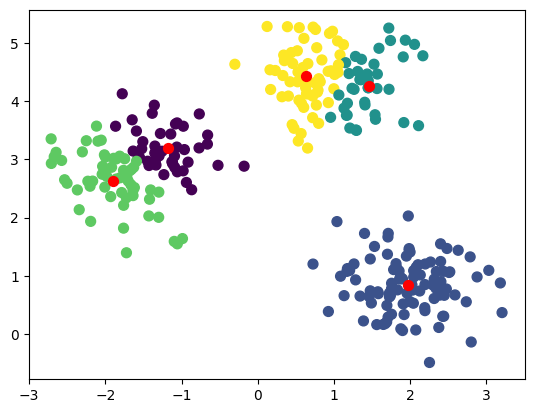

In [25]:
kmeans = KMeans(n_clusters=5)      # The number of clusters works an argument
kmeans.fit(X)                      # Training
y_kmeans = kmeans.predict(X)       # Prediction
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50);

To solve this problem, we can execute multiple $K-means$ with different number of groups and choose the one which meets a certain criteria. There are several criteria that allow us to measure "how well" the clusters have achieved. The two most famous criteria are the $Elbow$  and the $Silhouette$ methods. For more information, see the following link:

https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

We use $Silhoutte$ for two reasons:

* Already implemented in $sklearn$.
* The optimum number of groups is automatically extracted.

**This criteria is based on the idea that a point will belong to a group if it is very close to its centroid and very far from the another ones.**

See the following code:

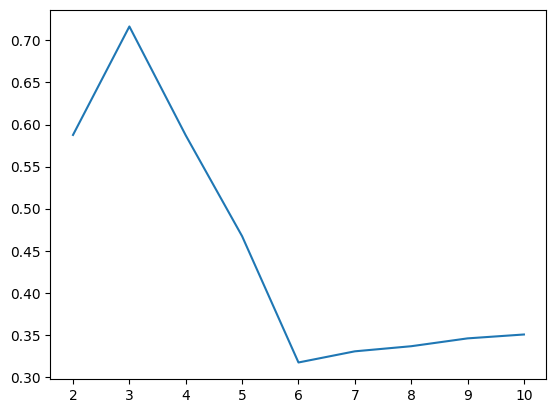

In [32]:
from sklearn.metrics import silhouette_score

scores = []
groups = np.arange(2, 11)  # 2, 3, 4, ..., 8, 9, 10

for k in groups:
  kmeans = KMeans(n_clusters = k, n_init = 10).fit(X)
  labels = kmeans.labels_
  scores.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(groups, scores)
plt.show()

The maximum value is $K=6$

[Check Silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) from scikit-learn

## Lineal Separation

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:

<ipython-input-33-c1d788e249ec>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')


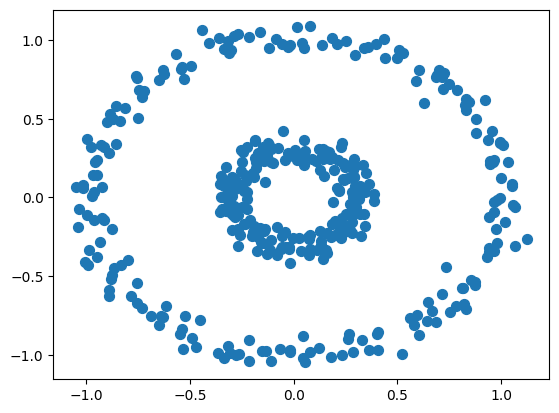

In [33]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=400, factor=.3, noise=.05)
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')

In [ ]:
help(make_circles)

Help on function make_circles in module sklearn.datasets._samples_generator:

make_circles(n_samples=100, *, shuffle=True, noise=None, random_state=None, factor=0.8)
    Make a large circle containing a smaller circle in 2d.
    
    A simple toy dataset to visualize clustering and classification
    algorithms.
    
    Read more in the :ref:`User Guide <sample_generators>`.
    
    Parameters
    ----------
    n_samples : int or tuple of shape (2,), dtype=int, default=100
        If int, it is the total number of points generated.
        For odd numbers, the inner circle will have one point more than the
        outer circle.
        If two-element tuple, number of points in outer circle and inner
        circle.
    
        .. versionchanged:: 0.23
           Added two-element tuple.
    
    shuffle : bool, default=True
        Whether to shuffle the samples.
    
    noise : float, default=None
        Standard deviation of Gaussian noise added to the data.
    
    random_sta

### Do the groups above have a linear separation?

In [34]:
# Use Kmeans from sklearn using 2 clusters

kmeans = KMeans(n_clusters = 2).fit(X)
y_kmeans = kmeans.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


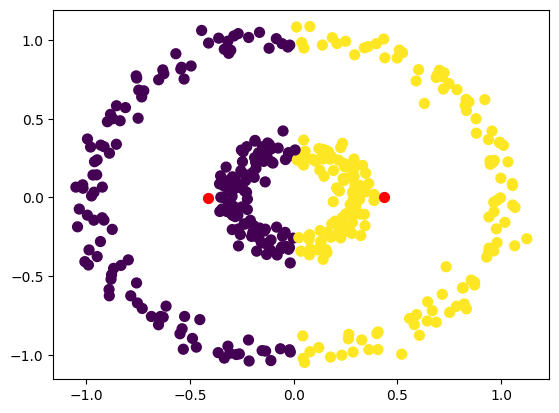

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)

In order to solve this, we can use a kernel transformation to project the data into a higher dimension where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the $SpectralClustering$ estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


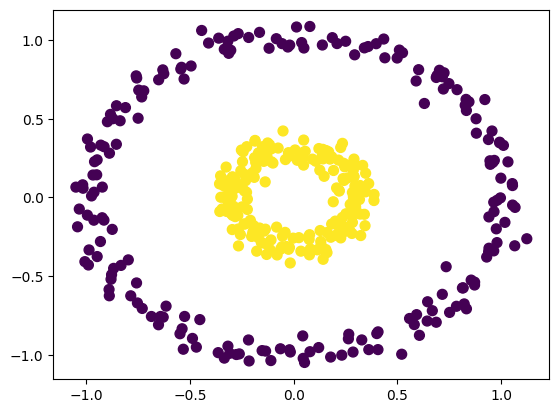

In [36]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

**In real cases**, it's hard to check if your clusters have a linear separation because of the number of dimensions. The approach will be to try different models and see how it works based on your requirements.

## Categorical Variables

The standard k-means algorithm isn't directly applicable to categorical data, for various reasons. The sample space for categorical data is discrete, and doesn't have a natural origin. A Euclidean distance function on such a space isn't really meaningful.

There's a variation of k-means known as k-modes, introduced in this paper by Zhexue Huang, which is suitable for categorical data:

http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf

An example in python:

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb